In [3]:
import phik
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

from warnings import filterwarnings
filterwarnings("ignore")

# Загрузка данных

In [4]:
# Features
features_names = [
    "name", "landmass", "zone", "area", "population", 
    "language", "religion", "bars", "stripes", "colours", 
    "red", "green", "blue", "gold", "white", 
    "black", "orange", "mainhue", "circles", "crosses", 
    "saltires", "quarters", "sunstars", "crescent", "triangle", 
    "icon", "animate", "text", "topleft", "botright"
]           
    
# DataFrame
flags_df = pd.read_csv("flag.csv")
flags_df.columns = columns=features_names
flags_df = flags_df.drop(columns="name")   # название страны не поможет в построении обобщающей модели
flags_df["label"] = flags_df["religion"] 
flags_df.drop(columns="religion", inplace=True)
flags_df.head()

,landmass,zone,area,population,language,bars,stripes,colours,red,green,...,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright,label
0,3,1,29,3,6,0,0,3,1,0,...,0,1,0,0,0,1,0,red,red,6
1,4,1,2388,20,8,2,0,3,1,1,...,0,1,1,0,0,0,0,green,white,2
2,6,3,0,0,1,0,0,5,1,0,...,0,0,0,1,1,1,0,blue,red,1
3,3,1,0,0,6,3,0,3,1,0,...,0,0,0,0,0,0,0,blue,red,0
4,4,2,1247,7,10,0,2,3,1,0,...,0,1,0,0,1,0,0,red,black,5


# Первичный анализ

In [5]:
flags_df.describe()

,landmass,zone,area,population,language,bars,stripes,colours,red,green,...,crosses,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,label
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,...,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,3.564767,2.217617,700.316062,23.305699,5.316062,0.455959,1.544041,3.455959,0.787565,0.466321,...,0.150259,0.093264,0.150259,1.388601,0.056995,0.139896,0.248705,0.202073,0.082902,2.191710
std,1.553625,1.308745,2176.570790,92.171685,3.489359,1.040522,2.331706,1.298789,0.410095,0.500162,...,0.386238,0.291559,0.436860,4.407531,0.232436,0.347782,0.433386,0.402590,0.276450,2.066482
min,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,9.000000,0.000000,2.000000,0.000000,0.000000,3.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,4.000000,2.000000,111.000000,4.000000,6.000000,0.000000,0.000000,3.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,5.000000,4.000000,463.000000,14.000000,9.000000,0.000000,3.000000,4.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
max,6.000000,4.000000,22402.000000,1008.000000,10.000000,5.000000,14.000000,8.000000,1.000000,1.000000,...,2.000000,1.000000,4.000000,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [6]:
print(f"Размерность: {flags_df.shape}")

Размерность: (193, 29)


In [7]:
pd.DataFrame(flags_df["label"].value_counts()).reset_index().sort_values(by="label").set_index("label")

,count
label,
0,40
1,60
2,35
3,8
4,4
5,27
6,15
7,4


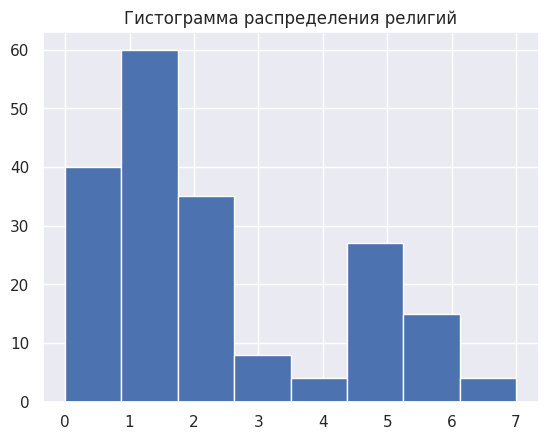

In [8]:
sns.set_theme()
plt.title("Гистограмма распределения религий")
flags_df["label"].hist(bins=8)
plt.xticks()
plt.show()

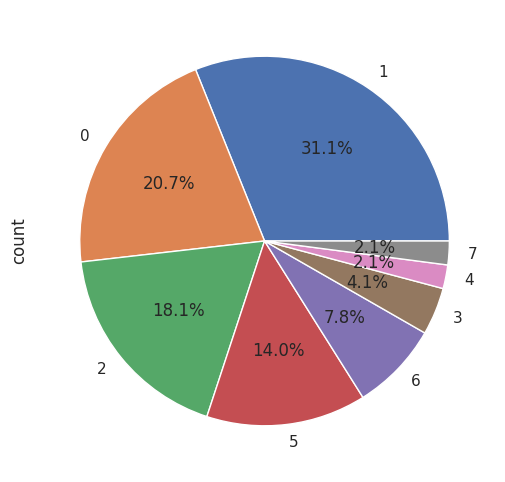

In [9]:
plt.figure(figsize=(6, 6))
flags_df["label"].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

In [10]:
pd.get_dummies(flags_df).shape

(193, 49)

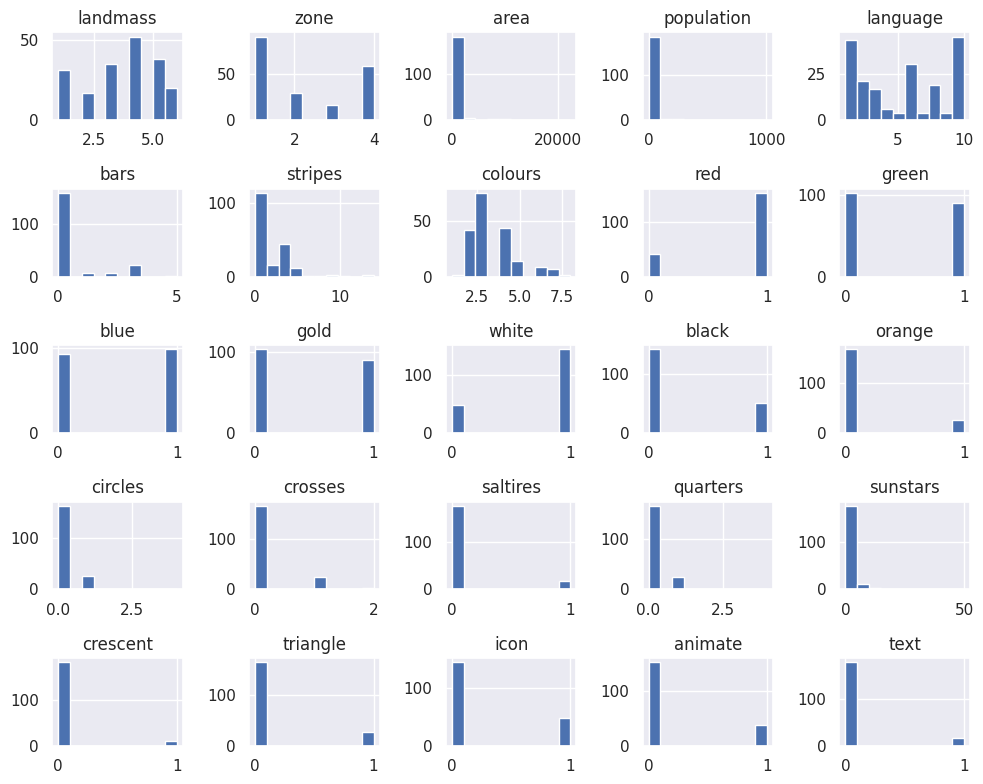

In [11]:
pd.get_dummies(flags_df.drop(columns="label")).hist(figsize=(10,8))
plt.tight_layout()
plt.show()

# Обучение модели на изначальных данных

In [12]:
X = pd.get_dummies(flags_df.drop(columns="label"))
y = flags_df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
model = GradientBoostingClassifier(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.87      1.00      0.93        13
           2       0.80      0.67      0.73         6
           4       0.00      0.00      0.00         1
           5       0.80      0.80      0.80         5
           6       0.60      1.00      0.75         3
           7       0.00      0.00      0.00         1

    accuracy                           0.85        39
   macro avg       0.58      0.62      0.59        39
weighted avg       0.82      0.85      0.82        39



# Поиск корреляций

interval columns not set, guessing: ['landmass', 'zone', 'area', 'population', 'language', 'bars', 'stripes', 'colours', 'red', 'green', 'blue', 'gold', 'white', 'black', 'orange', 'circles', 'crosses', 'saltires', 'quarters', 'sunstars', 'crescent', 'triangle', 'icon', 'animate', 'text', 'label']


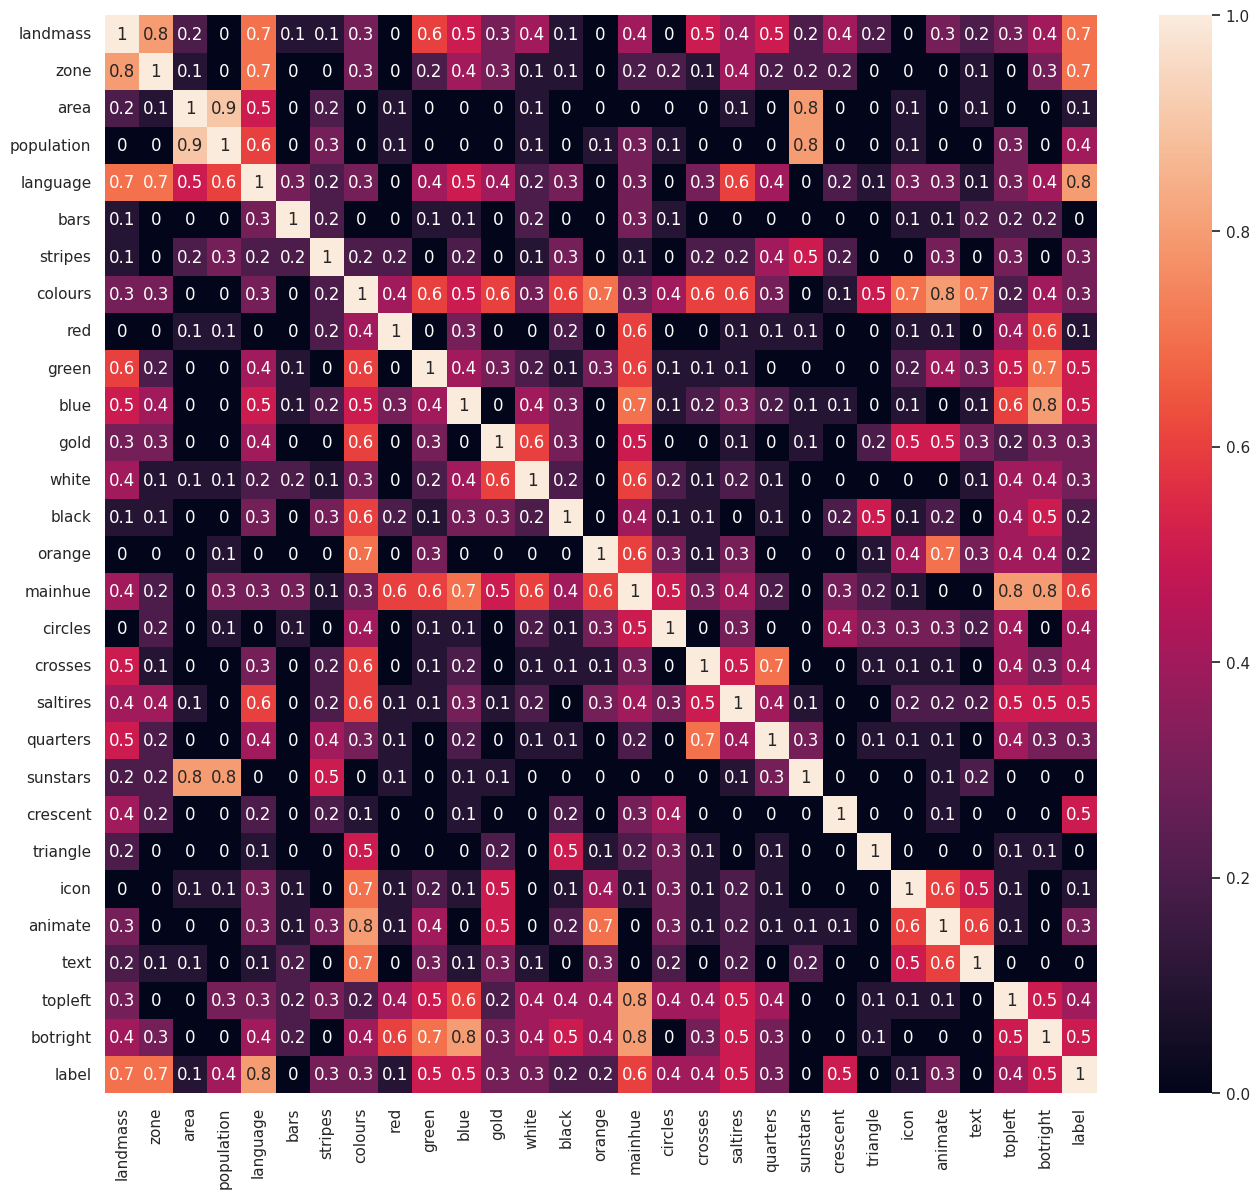

In [14]:
plt.figure(figsize=(16, 14))
sns.heatmap(
    flags_df.phik_matrix().round(1), annot=True
)
plt.show()

interval columns not set, guessing: ['landmass', 'zone', 'area', 'population', 'language', 'bars', 'stripes', 'colours', 'red', 'green', 'blue', 'gold', 'white', 'black', 'orange', 'circles', 'crosses', 'saltires', 'quarters', 'sunstars', 'crescent', 'triangle', 'icon', 'animate', 'text', 'label']


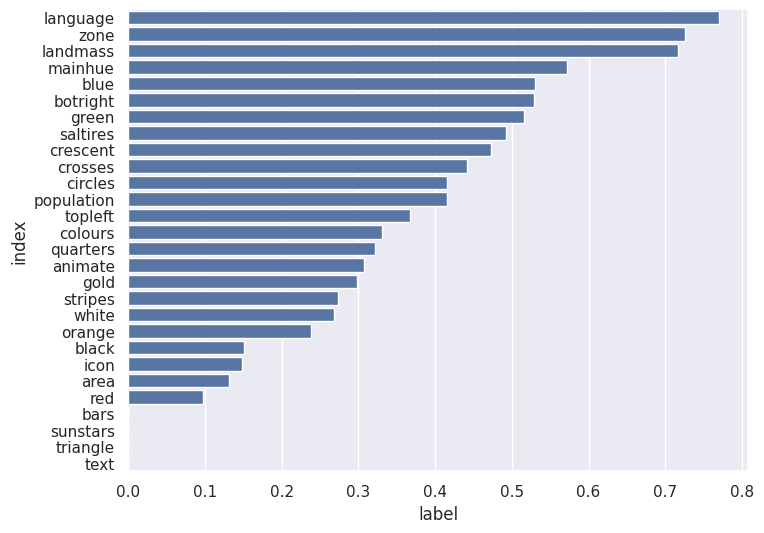

In [15]:
feat_phik_corr = pd.DataFrame(flags_df.phik_matrix()["label"]).reset_index().sort_values(by="label", ascending=False)
feat_phik_corr = feat_phik_corr[1:]
plt.figure(figsize=(8, 6))
sns.barplot(
    x=feat_phik_corr["label"],
    y=feat_phik_corr["index"],
    orient="y"
)
plt.show()

# Нормализация признаков

In [16]:
from sklearn.preprocessing import MinMaxScaler

norm_df = flags_df.copy()
norm_df = pd.get_dummies(norm_df.drop(columns="label"))
columns = list(norm_df)

In [17]:
min_max_norm = MinMaxScaler()
norm_df = min_max_norm.fit_transform(norm_df)
norm_df = pd.DataFrame(data=norm_df, columns=columns)
norm_df["label"] = flags_df["label"]
norm_df.describe()

,landmass,zone,area,population,language,bars,stripes,colours,red,green,...,topleft_white,botright_black,botright_blue,botright_brown,botright_gold,botright_green,botright_orange,botright_red,botright_white,label
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,...,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,0.512953,0.405872,0.031261,0.023121,0.479562,0.091192,0.110289,0.350851,0.787565,0.466321,...,0.212435,0.046632,0.243523,0.010363,0.046632,0.202073,0.005181,0.357513,0.088083,2.191710
std,0.310725,0.436248,0.097160,0.091440,0.387707,0.208104,0.166550,0.185541,0.410095,0.500162,...,0.410095,0.211398,0.430325,0.101532,0.211398,0.402590,0.071982,0.480514,0.284153,2.066482
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.000000,0.000402,0.000000,0.111111,0.000000,0.000000,0.285714,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.600000,0.333333,0.004955,0.003968,0.555556,0.000000,0.000000,0.285714,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.800000,1.000000,0.020668,0.013889,0.888889,0.000000,0.214286,0.428571,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [18]:
X = pd.get_dummies(norm_df.drop(columns="label"))
y = norm_df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [19]:
model = GradientBoostingClassifier(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.87      1.00      0.93        13
           2       0.80      0.67      0.73         6
           4       0.00      0.00      0.00         1
           5       0.80      0.80      0.80         5
           6       0.60      1.00      0.75         3
           7       0.00      0.00      0.00         1

    accuracy                           0.85        39
   macro avg       0.58      0.62      0.59        39
weighted avg       0.82      0.85      0.82        39



# Oversampling

In [20]:
from imblearn.over_sampling import RandomOverSampler

os_df = norm_df.copy()
os_df = pd.get_dummies(os_df)
columns = list(os_df)

In [21]:
?RandomOverSampler

Init signature:
RandomOverSampler(
    *,
    sampling_strategy='auto',
    random_state=None,
    shrinkage=None,
)
Docstring:     
Class to perform random over-sampling.

Object to over-sample the minority class(es) by picking samples at random
with replacement. The bootstrap can be generated in a smoothed manner.

Read more in the :ref:`User Guide <random_over_sampler>`.

Parameters
----------
sampling_strategy : float, str, dict or callable, default='auto'
    Sampling information to resample the data set.

    - When ``float``, it corresponds to the desired ratio of the number of
      samples in the minority class over the number of samples in the
      majority class after resampling. Therefore, the ratio is expressed as
      :math:`\alpha_{os} = N_{rm} / N_{M}` where :math:`N_{rm}` is the
      number of samples in the minority class after resampling and
      :math:`N_{M}` is the number of samples in the majority class.

        .. warning::
           ``float`` is only avail

In [22]:
over_sampler = RandomOverSampler() 
X_resample, y_resample = over_sampler.fit_resample(
    X=os_df[list(os_df.drop(columns="label"))],
    y=os_df["label"],
)

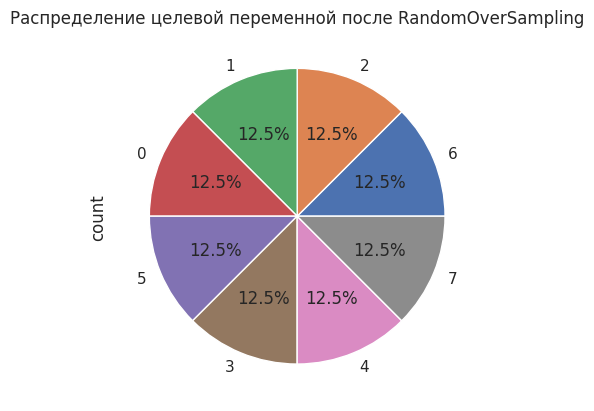

In [23]:
plt.title("Распределение целевой переменной после RandomOverSampling")
y_resample.value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.2, random_state=0)

In [25]:
model = GradientBoostingClassifier(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.88      0.93         8
           2       1.00      0.90      0.95        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        13
           5       0.85      1.00      0.92        11
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00        14

    accuracy                           0.98        96
   macro avg       0.98      0.97      0.97        96
weighted avg       0.98      0.98      0.98        96



# Отбор признаков

Будет отобрано 8 признаков

In [26]:
from sklearn.feature_selection import SequentialFeatureSelector

select_df = X_resample.copy()
select_df["label"] = y_resample
columns = list(select_df)
select_df.head()

,landmass,zone,area,population,language,bars,stripes,colours,red,green,...,topleft_white,botright_black,botright_blue,botright_brown,botright_gold,botright_green,botright_orange,botright_red,botright_white,label
0,0.4,0.000000,0.001295,0.002976,0.555556,0.0,0.000000,0.285714,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6
1,0.6,0.000000,0.106598,0.019841,0.777778,0.4,0.000000,0.285714,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
2,1.0,0.666667,0.000000,0.000000,0.000000,0.0,0.000000,0.571429,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,0.4,0.000000,0.000000,0.000000,0.555556,0.6,0.000000,0.285714,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0.6,0.333333,0.055665,0.006944,1.000000,0.0,0.142857,0.285714,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [27]:
sfs = SequentialFeatureSelector(
    estimator=GradientBoostingClassifier(random_state=0),
    n_features_to_select=8,
    cv=5,
    n_jobs=-1
)
sfs.fit(
    X=select_df[list(select_df.drop(columns="label"))],
    y=select_df["label"],
)
best_features = sfs.get_feature_names_out()
print(best_features)

['landmass' 'zone' 'area' 'population' 'language' 'colours' 'orange'
 'icon']


interval columns not set, guessing: ['landmass', 'area', 'population', 'language', 'bars', 'green', 'saltires', 'crescent', 'label']


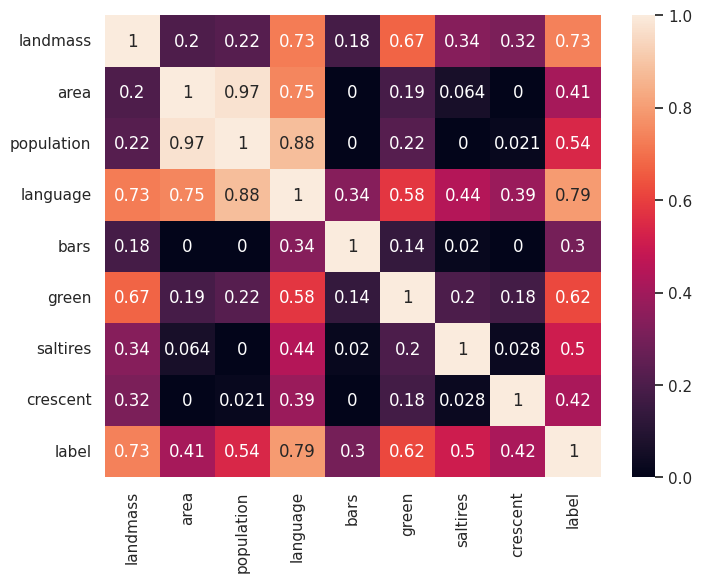

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(select_df[['landmass', 'area', 'population', 'language', 'bars', 'green', 'saltires', 'crescent', 'label']].phik_matrix(), annot=True)
plt.show()

In [29]:
X = select_df[best_features]
y = select_df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [63]:
model = GradientBoostingClassifier(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.50      0.50      0.50         2
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         6
           5       0.80      1.00      0.89         4
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         4

    accuracy                           0.91        35
   macro avg       0.88      0.88      0.88        35
weighted avg       0.92      0.91      0.91        35



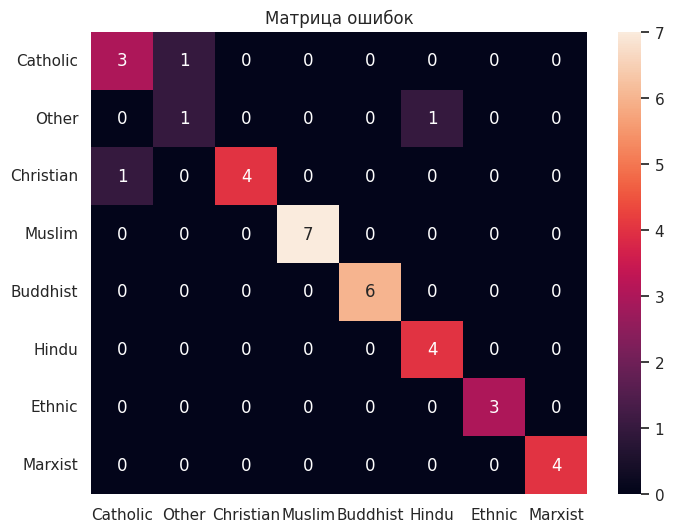

In [64]:
confusion = confusion_matrix(y_pred=y_pred, y_true=y_test)
religion = ["Catholic", "Other", "Christian", "Muslim", "Buddhist", "Hindu", "Ethnic", "Marxist"]
plt.figure(figsize=(8, 6))
plt.title("Матрица ошибок")
sns.heatmap(confusion, annot=True, xticklabels=religion, yticklabels=religion)
plt.show()

# Подбор параметров модели и работа с выбросами

In [100]:
from sklearn.model_selection import GridSearchCV

df = select_df.copy()
df.shape

(480, 49)

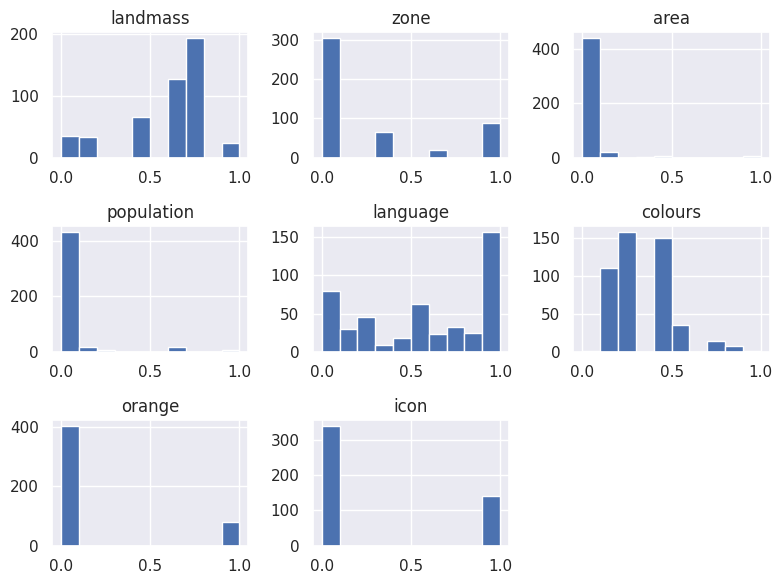

In [73]:
df[best_features].hist(figsize=(8, 6))
plt.tight_layout()
plt.show()

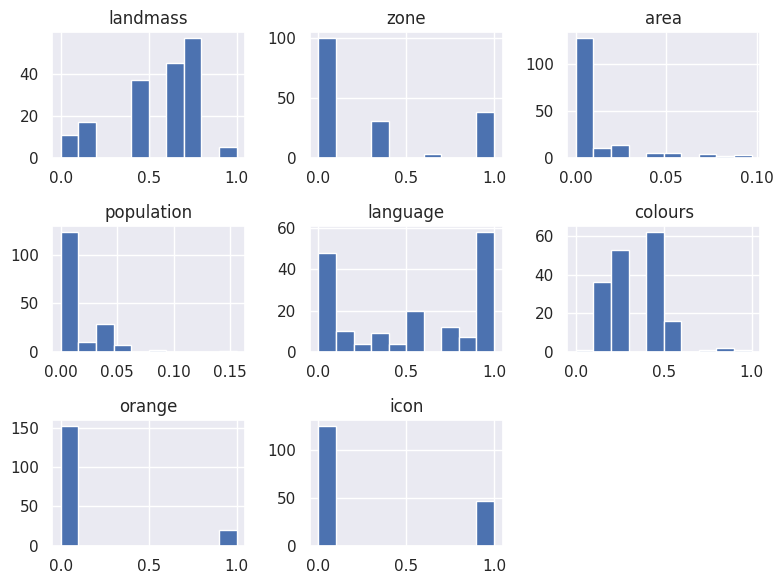

In [74]:
df = df.query("area<0.1")
df = df.query("saltires<0.05")
df = df.query("sunstars<0.01")
df = df.query("bars<0.2")
df[best_features].hist(figsize=(8, 6))
plt.tight_layout()
plt.show()

In [80]:
df.shape

(172, 49)

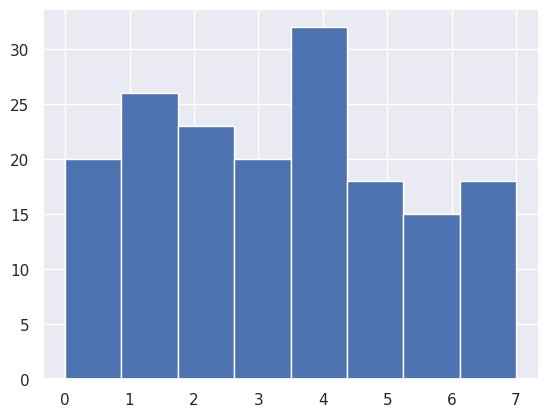

In [85]:
df["label"].hist(bins=8)
plt.show()

In [109]:
X = df[best_features]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
grid = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=0),
    param_grid={
        "random_state": [0],
        "n_estimators": range(100, 501, 100),
        "max_depth": range(1, 6, 1),
        "min_samples_split": range(10, 51, 10),
        "min_samples_leaf": range(10, 51, 10),
    },
    cv=5,
    n_jobs=-1,
)
# grid.fit(X_train, y_train)
# {'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 0}
print(grid.best_params_)

In [118]:
model = GradientBoostingClassifier(
    n_estimators=100, 
    max_depth=2, 
    min_samples_leaf=10, 
    min_samples_split=10,
    random_state=0
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        19
           1       1.00      0.62      0.77         8
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        13
           5       0.92      1.00      0.96        11
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00        14

    accuracy                           0.97        96
   macro avg       0.98      0.95      0.96        96
weighted avg       0.97      0.97      0.97        96



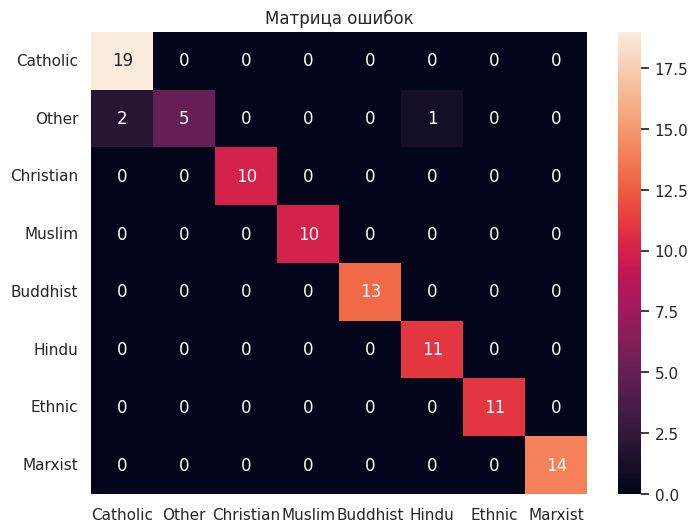

In [119]:
confusion = confusion_matrix(y_pred=y_pred, y_true=y_test)
religion = ["Catholic", "Other", "Christian", "Muslim", "Buddhist", "Hindu", "Ethnic", "Marxist"]
plt.figure(figsize=(8, 6))
plt.title("Матрица ошибок")
sns.heatmap(confusion, annot=True, xticklabels=religion, yticklabels=religion)
plt.show()

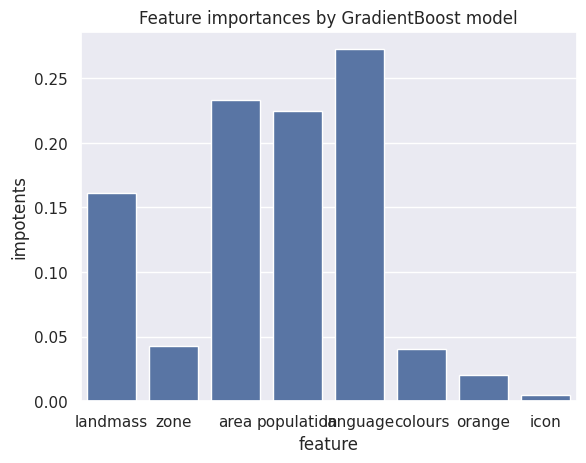

In [143]:
boost_FI = pd.DataFrame({"feature": list(df[best_features]), "impotents": model.feature_importances_})
plt.title("Feature importances by GradientBoost model")
sns.barplot(
    x=boost_FI["feature"],
    y=boost_FI["impotents"]
)
plt.show()

# Стэкинг

In [125]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [128]:
stack_model = StackingClassifier(
    estimators = [
        ('rf', RandomForestClassifier(n_estimators=10, random_state=0)),
        ('svr', make_pipeline(
            StandardScaler(),
            LinearSVC(random_state=0)
            )
        )
    ],
    final_estimator=LogisticRegression(random_state=0),
    
)
stack_model.fit(X_train, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=0)),
                               ('svr',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('linearsvc',
                                                 LinearSVC(random_state=0))]))],
                   final_estimator=LogisticRegression(random_state=0))

In [129]:
y_pred = stack_model.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.75      0.86         8
           2       1.00      0.80      0.89        10
           3       1.00      1.00      1.00        10
           4       0.87      1.00      0.93        13
           5       0.92      1.00      0.96        11
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00        14

    accuracy                           0.96        96
   macro avg       0.97      0.94      0.95        96
weighted avg       0.96      0.96      0.96        96

